# Add the lasa.py file in same directory as the jupyter notebook

In [1]:
!pip install gmr
import gmr
import matplotlib.pyplot as plt
import numpy as np

from lasa import load_lasa

## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x, show_start_end=True, **kwargs):
    """
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    """
    if show_start_end:
        start_label, end_label = "start", "end"
    else:
        start_label, end_label = None, None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0, 0], x[t][0, 1], c="k", label=start_label)
        plt.scatter(x[t][-1, 0], x[t][-1, 1], c="b", label=end_label)
        plt.plot(x[t][:, 0], x[t][:, 1], **kwargs)
        if t == 0:
            kwargs.pop("label", None)
            start_label, end_label = None, None

    plt.legend()


def streamplot(f, x_axis=(0, 100), y_axis=(0, 100), n=1000, width=1, **kwargs):
    """
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    """
    a, b = np.linspace(x_axis[0], x_axis[1], n), np.linspace(y_axis[0], y_axis[1], n)
    X, Y = np.meshgrid(a, b)
    X_test = np.stack([X, Y], axis=-1).reshape(-1, 2)
    Y_pred = f(X_test)
    U, V = np.split(Y_pred.reshape(n, n, 2), 2, axis=-1)
    U, V = U[..., 0], V[..., 0]
    speed = np.sqrt(U**2 + V**2)
    lw = width * speed / speed.max()
    plt.streamplot(X, Y, U, V, linewidth=lw, **kwargs)


# gets the velocity x_dot given x
def derivative(x):
    """
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    """
    xds = []

    for i in range(x.shape[0]):
        dt = 1 / (x[i].shape[0] - 1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt, np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0, np.pi / 2, len(xd))) ** 2
        xd = xd * (v_factor[..., None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd


# loading the data and plotting
def load_data(letter):
    """
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    """
    letter2id = dict(c=2, j=6, s=24)
    assert letter.lower() in letter2id
    _, x, _, _, _, _ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1, 2)
    xd = xd.reshape(-1, 2)
    plt.show()
    return data, x, xd

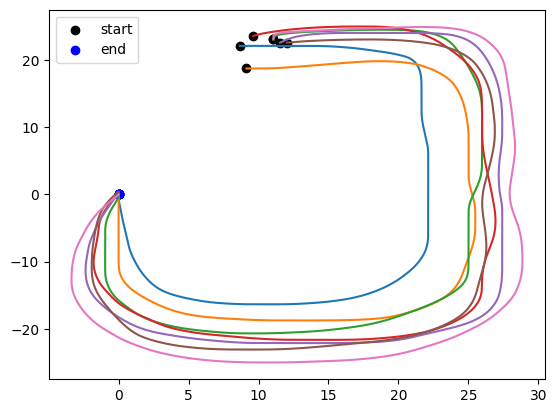

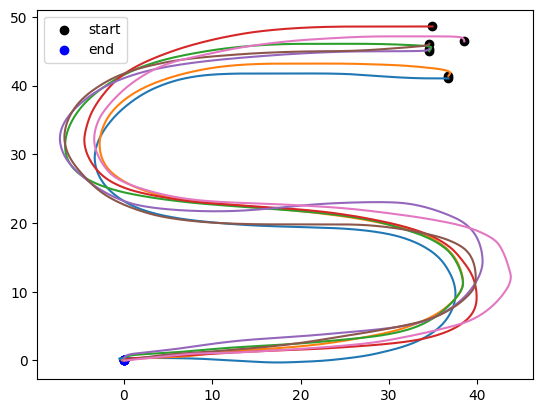

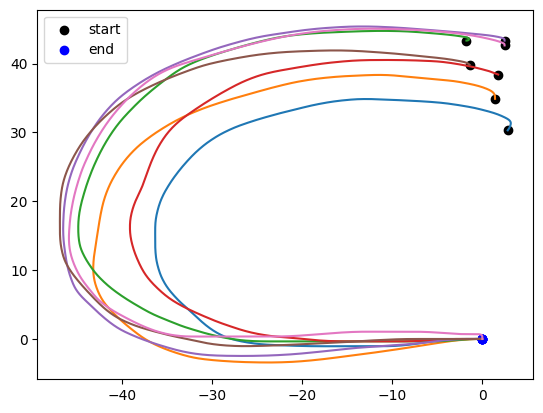

In [3]:
# letter should be one of c,j,s
data, x, xd = load_data("j")
data, x, xd = load_data("s")
data, x, xd = load_data("c")

# PART-1 : Linear Least Squares (LLS)

In [4]:
class LeastSquares:

    def __init__(self, lam=1e-2, bias=False):

        self.bias = bias
        self.lam = lam

    def fit(self, X, Y):
        """
        store the weight matrix into self.w

        self.w should be array of shape (3,2) if bias is enabled and
        (2,2) if bias is False


        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        """
        ########################
        # YOUR CODE HERE

        # If bias is enabled, add a column of ones to X.
        if self.bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # w = (X^T X + lam * I)^(-1) X^T Y
        d = X.shape[1]  # number of columns in design matrix
        self.w = np.linalg.inv(X.T @ X + self.lam * np.eye(d)) @ (X.T @ Y)

        ########################

    def predict(self, X):
        """
        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        """
        ###########################
        # YOUR CODE HERE

        if self.bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return X @ self.w

        ###########################

    def ode_differential(self, x, t):
        """
        function used for rk4 simulation
        """
        return self.predict(x[None])[0]

    def rk4_sim(self, t0, t_end, x0, f, dt=1e-3):
        """
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        """
        # Calculate slopes
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        while t <= t_end:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)

            # Calculate new x and y
            x = x + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list), np.array(t_list)

    def imitate(self, x0, t_end=5):
        """
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        """
        f = self.ode_differential
        return self.rk4_sim(0, t_end, x0, f)

# Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1 Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

In [5]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS


def fit_least_squares(letter, lam=1e-2, bias=False):
    # load data
    data, x, xd = load_data(letter)

    # fitting the model to data
    model = LeastSquares(lam=lam, bias=bias)
    model.fit(x, xd)

    # starting point for imitation
    x0 = data[6][0]
    x_rk4, t_tk4 = model.imitate(x0, t_end=10)

    # plots for generated trajectory
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.3, c="g", label="demonstrations")
    plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

    # vector field plot using stream line
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.5, c="b", label="demonstrations")

    streamplot(
        model.predict,
        x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
        y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
        width=3,
        color="g",
    )


def fit_least_squares_on_dataset(dataset, lam=1e-2):
    print(f"Dataset: {dataset}")
    fit_least_squares(dataset, lam=lam, bias=False)
    fit_least_squares(dataset, lam=lam, bias=True)
    return None


####################

### Dataset 'c'

Dataset: c


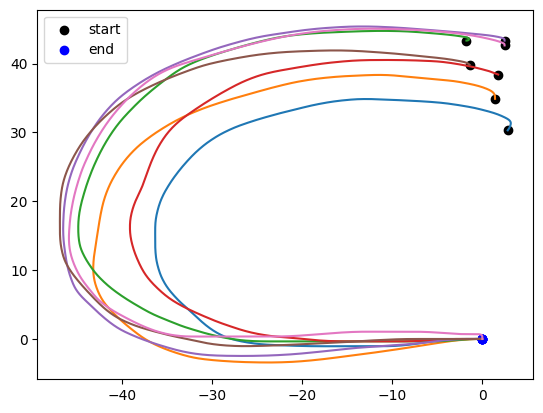

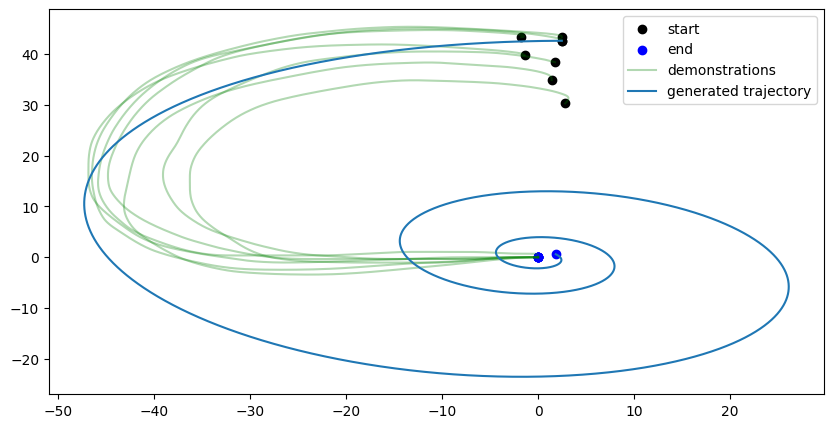

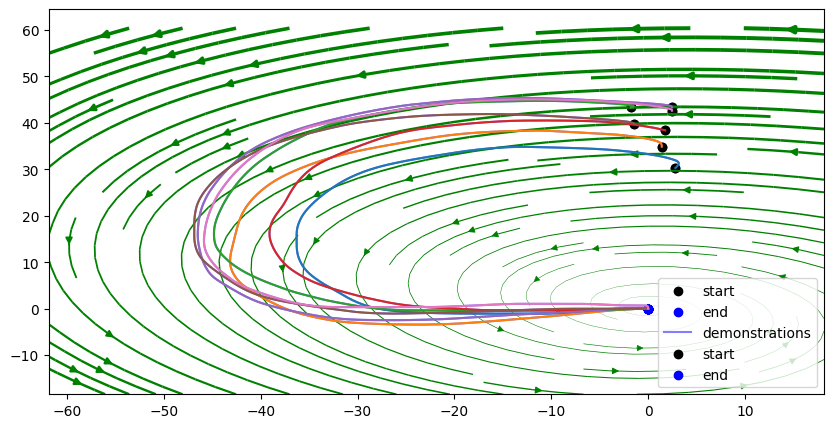

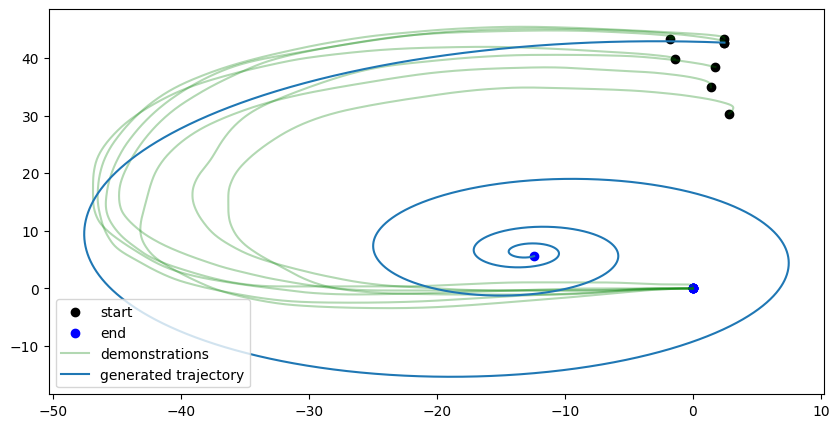

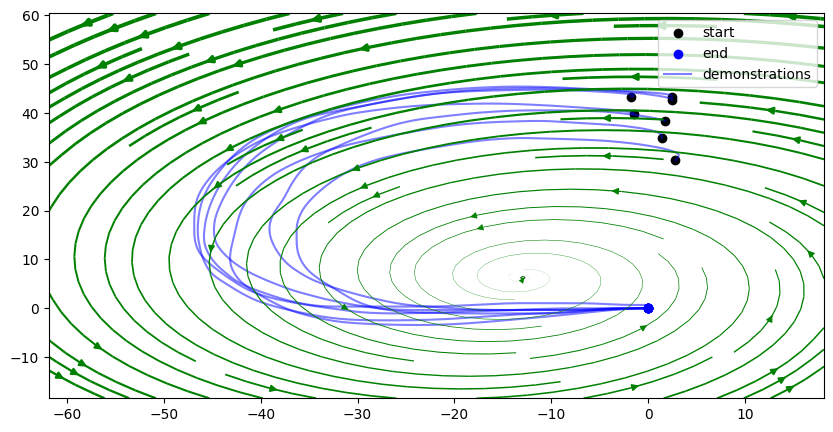

In [6]:
fit_least_squares_on_dataset(dataset="c")

Dataset 'c'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field.


### Dataset 'j'

Dataset: j


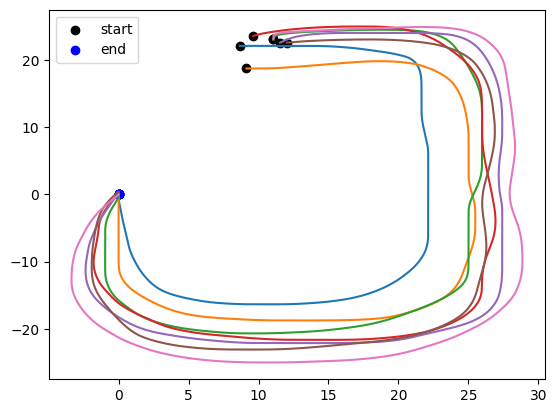

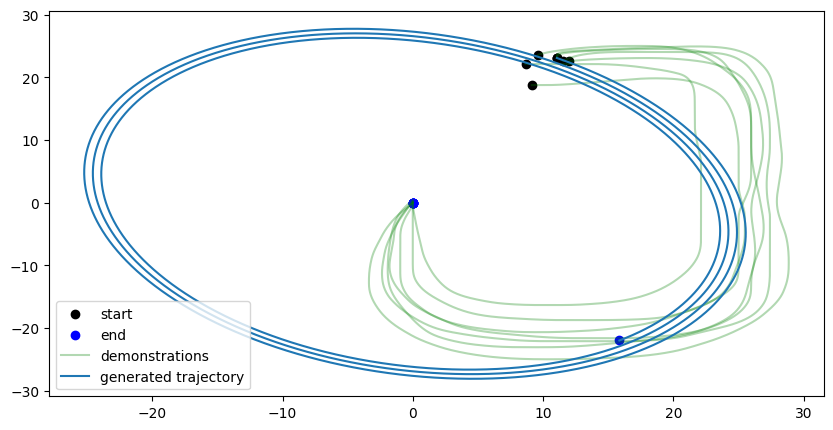

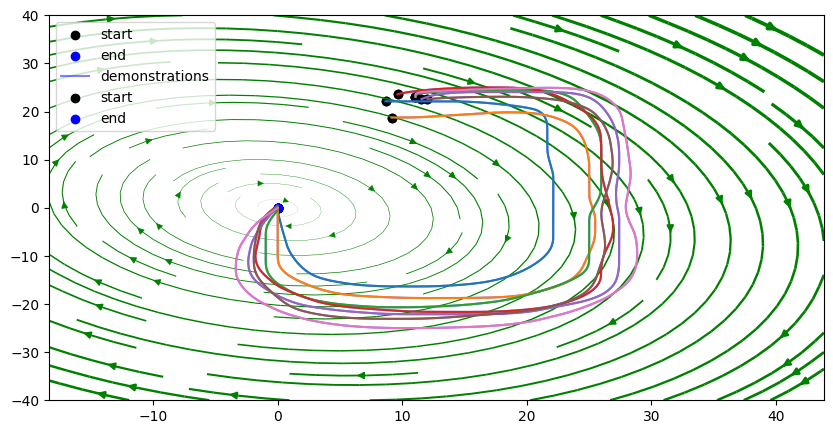

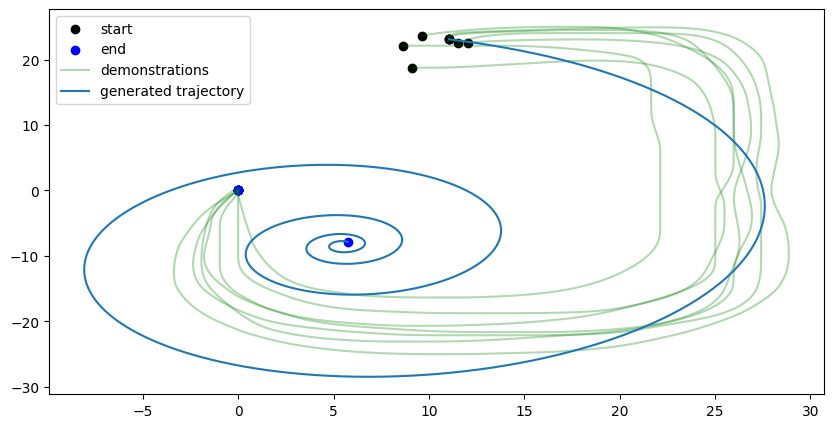

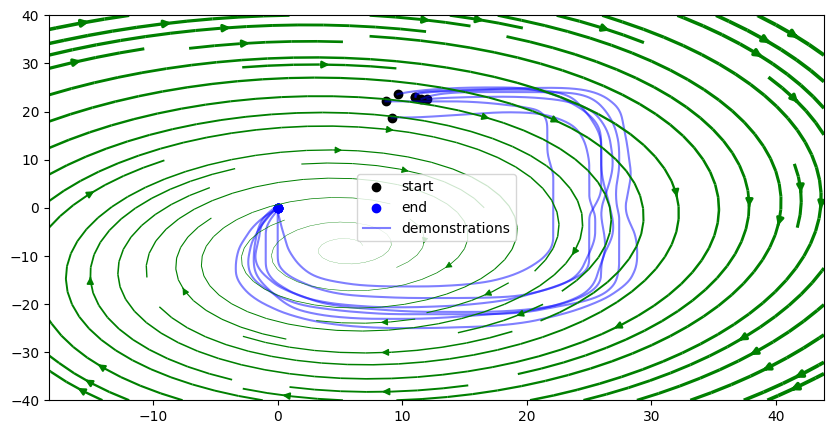

In [7]:
fit_least_squares_on_dataset("j")

Dataset 'j'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.
Although in this case, the convergence seems rather slower than in the previous "c" dataset.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field, although the fit is still bad.


### Dataset 's'

Dataset: s


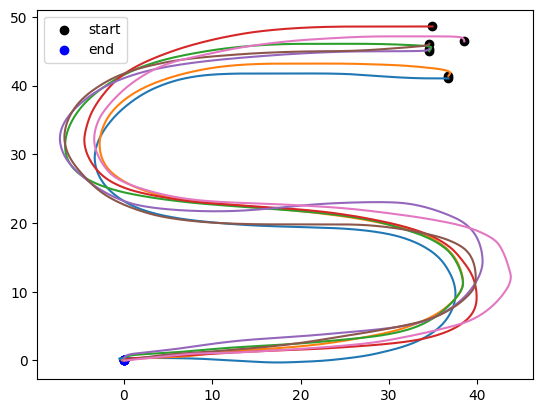

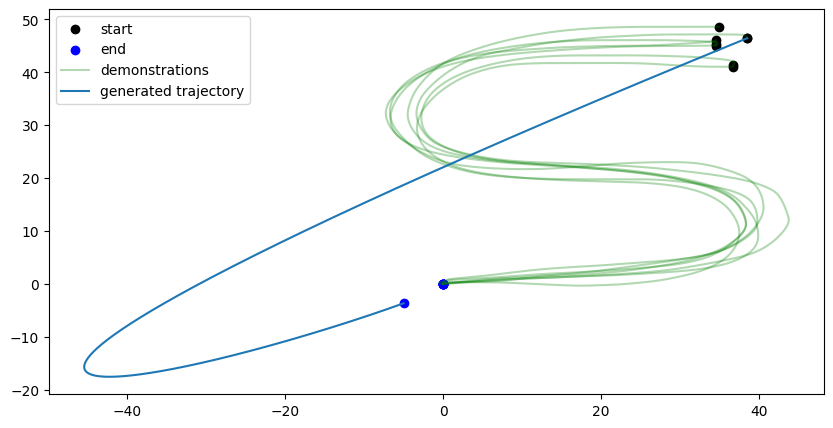

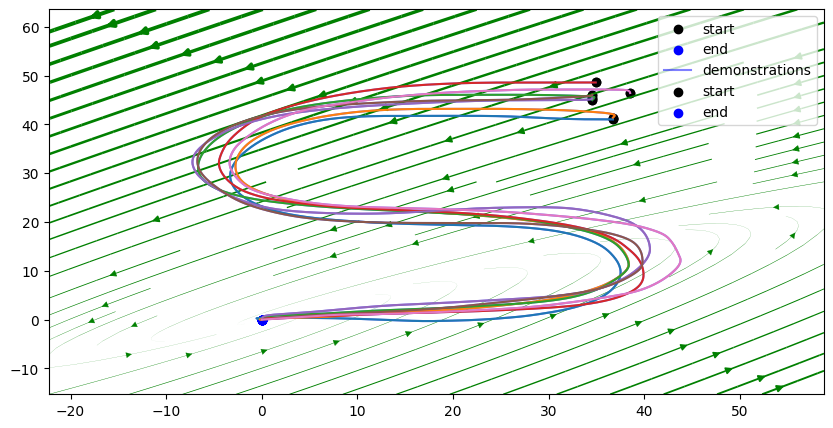

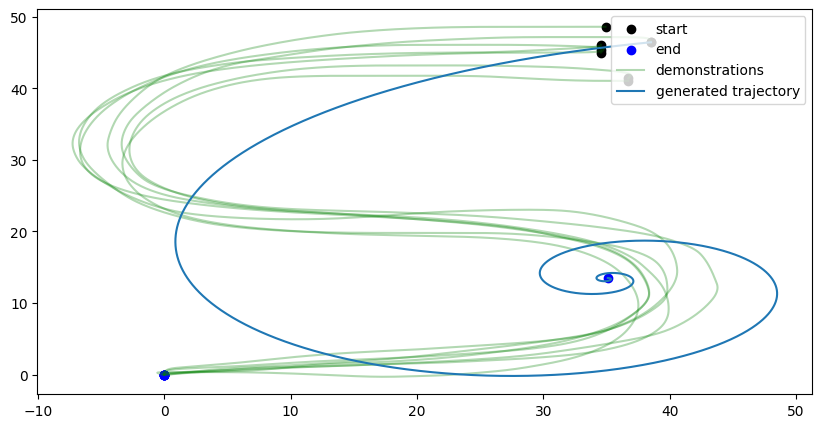

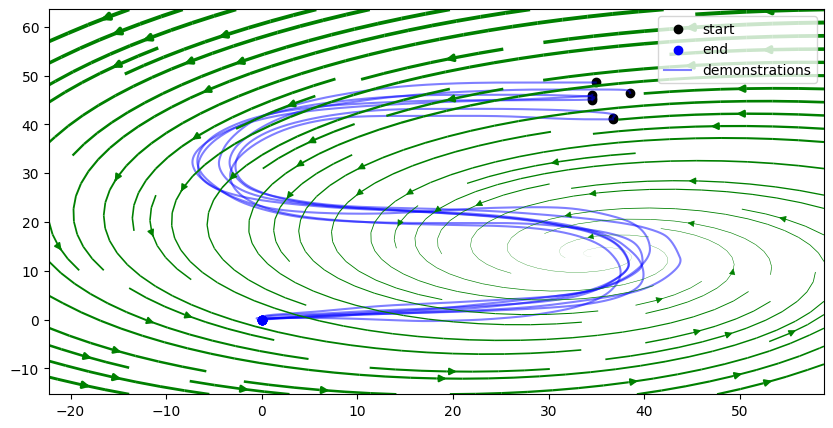

In [8]:
fit_least_squares_on_dataset("s")

Dataset 's'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.
It can be observed that the fit is very bad in this case.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field, better than without bias.
Although there are some initial points in the vector field starting from which, the convergence is bad.


# PART-2 Locally Weighted Regression (LWR)

[GMR](https://alexanderfabisch.github.io/gmr/#gmr.MVN) is handy package that helps us to deal with gaussian distributions. \\
some notable methods that you can use are *from_samples*,*to_norm_factor_and_exponents*,*condition*. \\
we can also visualize gaussians with *plot_error_ellipse* function


In [9]:
def init_gaussians(y, n=3):
    """
    initializes the gaussian based on time fragmentaion

    params:
        y : array of shape (number of trajectories,number of timesteps,2)
    returns:
        mvns: list of gmr.MVN() initialized objects
    """
    l = y.shape[1] // n
    y_split = [
        y[:, i * l :] if i == n - 1 else y[:, i * l : (i + 1) * l] for i in range(n)
    ]
    mvns = [gmr.MVN().from_samples(x.reshape(-1, 2)) for x in y_split]
    splot = plt.subplot(111)
    plot_curves(y)
    for mvn in mvns:
        gmr.plot_error_ellipse(splot, mvn, factors=[1])
    return mvns

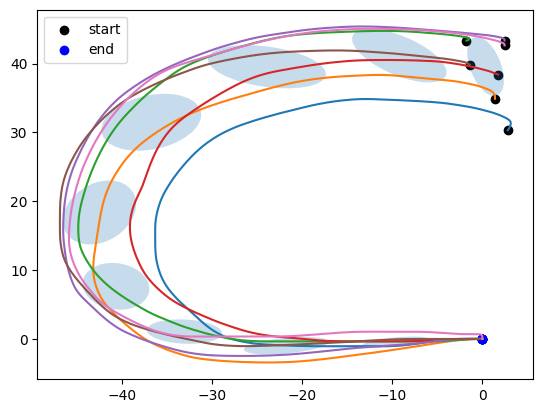

In [10]:
# basis functions initializes with gaussians from data
mvns = init_gaussians(data, 10)

In [11]:
import numpy as np


class LWR:
    def __init__(self, mvns, bias=True):
        """
        Parameters:
          mvns: list of Gaussian parameters (each as a dict with keys 'mean', 'cov', and optionally 'weight').
          bias: if True, the linear mapping is X_augmented @ W (i.e. X concatenated with 1’s for a bias term).
        """
        self.mvns = mvns
        self.bias = bias
        self.ws = None  # Will hold the weight matrices after fitting

    def fit(self, X, Y):
        """
        Fit a local weighted regression model for each Gaussian in mvns.
        For each Gaussian, a weight matrix is computed using weighted least squares.

        Parameters:
            X : array of shape (n_points, d)  (e.g. d=2)
            Y : array of shape (n_points, d_out) (e.g. d_out=2)

        After calling fit(), self.ws is a list where each element is a weight matrix.
        If bias is True, each weight matrix has shape ((d+1), d_out); if False, shape (d, d_out).
        """

        if self.bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        self.ws = []
        for mvn in self.mvns:
            nfe = mvn.to_norm_factor_and_exponents(X)[0][:, None]
            W = np.linalg.inv(X.T @ (nfe * X) + 1e-6 * np.eye(X.shape[1])) @ (
                X.T @ (nfe * Y)
            )
            self.ws.append(W)

    def predict(self, X):
        """
        Predict outputs for input X by averaging the predictions of all local models.

        Parameters:
            X : array of shape (n_points, d)

        Returns:
            predictions : array of shape (n_points, d_out)
        """
        """Compute the probability density function for given samples."""

        if self.bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        predictions = np.zeros((X.shape[0], self.ws[0].shape[1]))
        for i, mvn in enumerate(self.mvns):
            predictions += X @ self.ws[i] * mvn.pdf(X)
        return predictions

    def ode_differential(self, x, t):
        """
        Differential function for RK4 simulation.
        """
        # x[None] makes x a 2D array with one row.
        return self.predict(x[None])[0]

    def rk4_sim(self, t0, t_end, x0, f, dt=1e-3):
        """
        Simulate the ODE using the 4th-order Runge-Kutta (RK4) method.

        Parameters:
            t0   : starting time
            t_end: ending time
            x0   : initial state (array of shape (d,))
            f    : function f(x, t) that computes the derivative
            dt   : time step

        Returns:
            x_array: array of shape (n_steps, d)
            t_array: array of shape (n_steps,)
        """
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        while t <= t_end:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)
            x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
            t = t + dt
            x_list.append(x)
            t_list.append(t)
        return np.array(x_list), np.array(t_list)

    def imitate(self, x0, t_end=5):
        """
        Generate an imitation trajectory starting from x0.

        Parameters:
            x0   : initial state (array of shape (d,))
            t_end: simulation end time (default 5)

        Returns:
            x_rk4 : simulated data (array of shape (n_steps, d))
            t_rk4 : time stamps (array of shape (n_steps,))
        """
        return self.rk4_sim(0, t_end, x0, self.ode_differential)

In [12]:
def fit_lwr(letter, n=10, bias=False):
    # load data
    data, x, xd = load_data(letter)

    # initialize gaussians
    mvns = init_gaussians(data, n=n)

    # fitting the model to data
    model = LWR(mvns, bias=bias)
    model.fit(x, xd)

    # starting point for imitation
    x0 = data[6][0]
    x_rk4, t_tk4 = model.imitate(x0, t_end=10)

    # plots for generated trajectory
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.3, c="g", label="demonstrations")
    plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

    # vector field plot using stream line
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.5, c="b", label="demonstrations")

    streamplot(
        model.predict,
        x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
        y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
        width=3,
        color="g",
    )


def fit_lwr_on_dataset(letter):
    print(f"Dataset: {letter}")
    fit_lwr(letter, n=10, bias=False)
    fit_lwr(letter, n=10, bias=True)
    return None

# Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Dataset: c


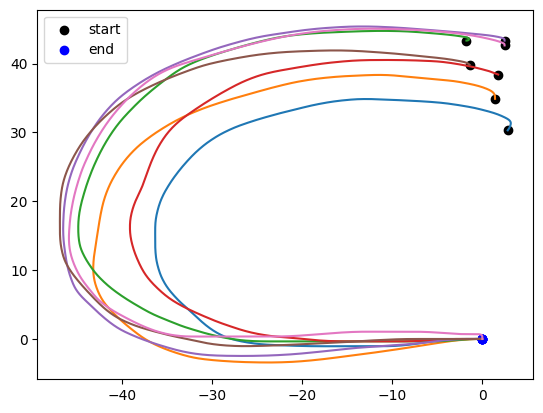

TypeError: 'float' object is not subscriptable

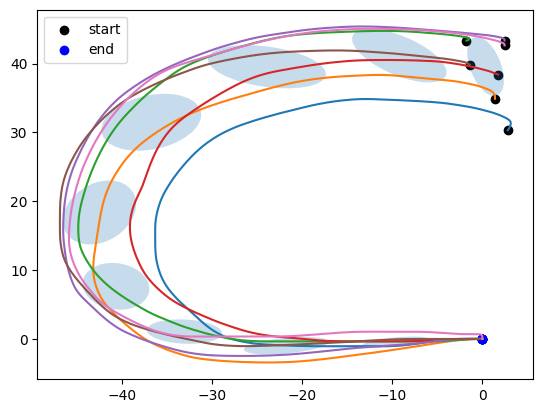

In [13]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS

fit_lwr_on_dataset("c")

####################

***for "S" Dataset*** \\
Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

Dataset: s


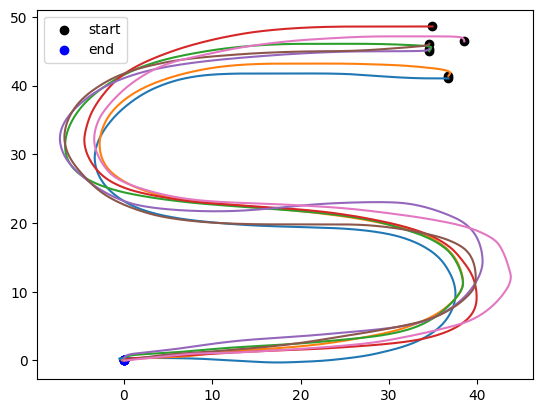

ValueError: cannot reshape array of size 1000000 into shape (1000,1000,2)

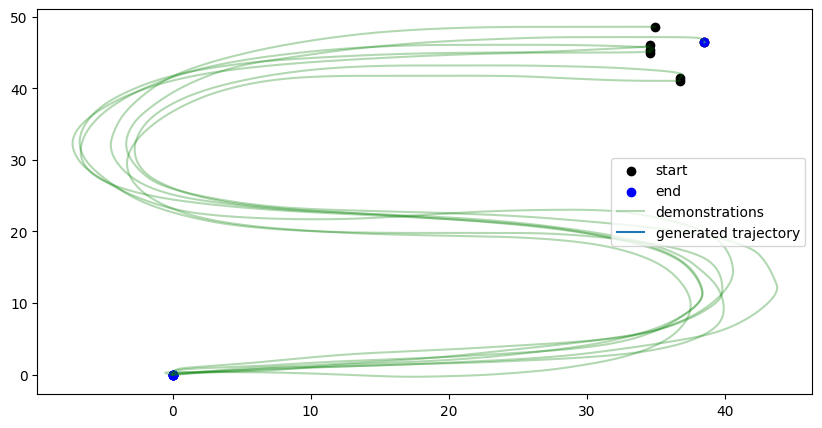

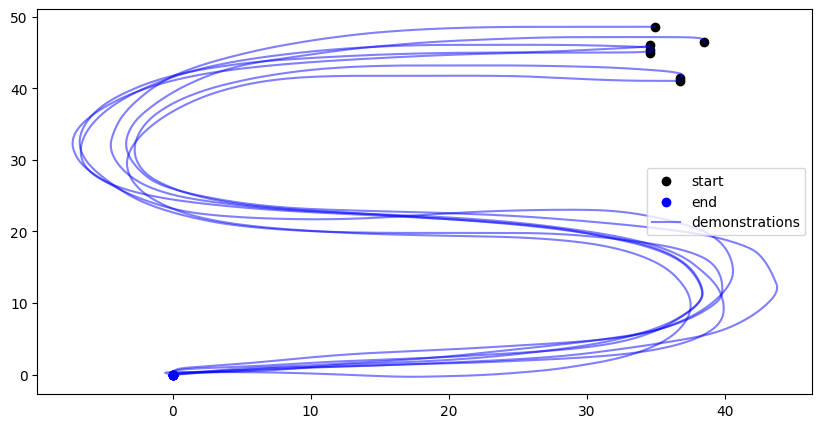

In [ ]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS

fit_lwr_on_dataset("s")

####################

# LLS vs LWR

Q1.which one generalizes better? Why? \\
Ans:

Q2.Does any one of the algorithms gives gaurentees of global attracter? \\
Ans:


1.

LWR generally provides a better fit to the data as it can capture local variations in the trajectories more effectively. LWR uses multiple local models (Gaussians) to approximate the data, which allows it to adapt to changes in the data distribution more flexibly than LLS.
However, LLS with a bias term can still perform well in cases where the data is more linear or has a global trend that can be captured by a single model. LWR might overfit in such cases if not properly regularized or if too many Gaussians are used.

2.

In terms of global attractor guarantees, neither LLS nor LWR inherently guarantees a global attractor. The performance and stability depend on the specific data and how well the model parameters are tuned.
So, basically, this choice is very much dependent on the specific data and the desired characteristics of the model.

# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment3.ipynb**